In [11]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import accuracy_score, f1_score
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import MultinomialNB

import matplotlib.pyplot as plt
import re
import string


RANDOM_STATE = 42

# CSV path for the Kaggle Jigsaw dataset
df = pd.read_csv("/content/train.csv")  # change path if needed

# Show basic info
df.head(), df.tail(), df.shape


(                 id                                       comment_text  toxic  \
 0  0000997932d777bf  Explanation\nWhy the edits made under my usern...      0   
 1  000103f0d9cfb60f  D'aww! He matches this background colour I'm s...      0   
 2  000113f07ec002fd  Hey man, I'm really not trying to edit war. It...      0   
 3  0001b41b1c6bb37e  "\nMore\nI can't make any real suggestions on ...      0   
 4  0001d958c54c6e35  You, sir, are my hero. Any chance you remember...      0   
 
    severe_toxic  obscene  threat  insult  identity_hate  
 0             0        0       0       0              0  
 1             0        0       0       0              0  
 2             0        0       0       0              0  
 3             0        0       0       0              0  
 4             0        0       0       0              0  ,
                       id                                       comment_text  \
 159566  ffe987279560d7ff  ":::::And for the second time of asking, whe

In [12]:
label_cols = [
    "toxic", "severe_toxic", "obscene",
    "threat", "insult", "identity_hate"
]

df[label_cols].sum()

,0
toxic,15294
severe_toxic,1595
obscene,8449
threat,478
insult,7877
identity_hate,1405


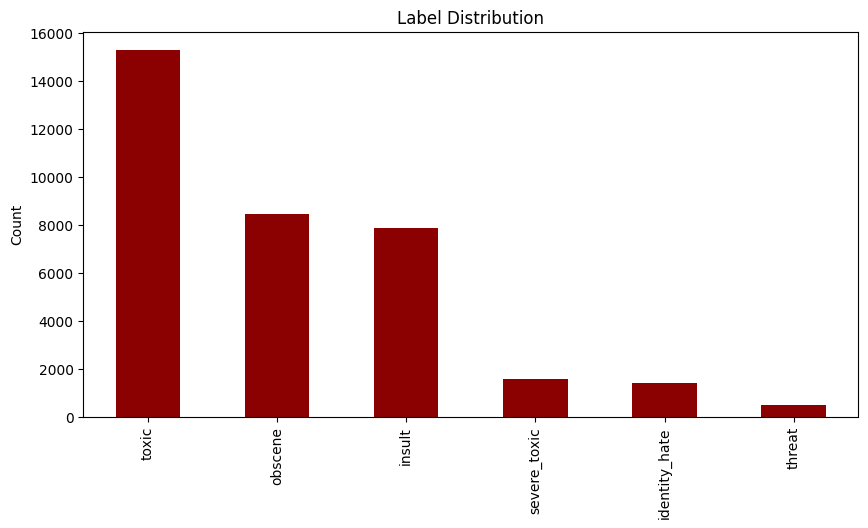

In [15]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10,5))
df[label_cols].sum().sort_values(ascending=False).plot(kind='bar', color='darkred')
plt.title("Label Distribution")
plt.ylabel("Count")
plt.show()

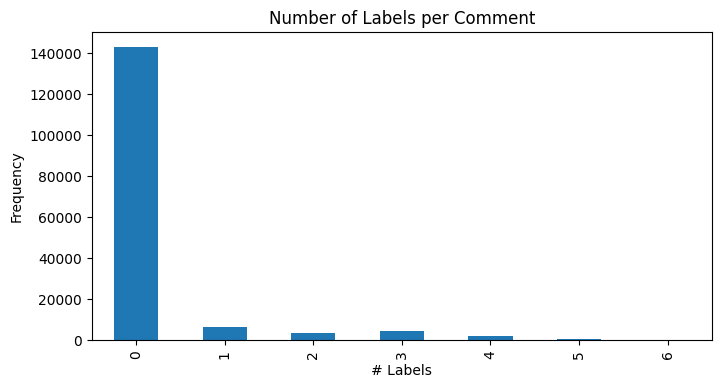

In [14]:
df["num_labels"] = df[label_cols].sum(axis=1)

df["num_labels"].value_counts().sort_index()

plt.figure(figsize=(8,4))
df["num_labels"].value_counts().sort_index().plot(kind='bar')
plt.title("Number of Labels per Comment")
plt.xlabel("# Labels")
plt.ylabel("Frequency")
plt.show()

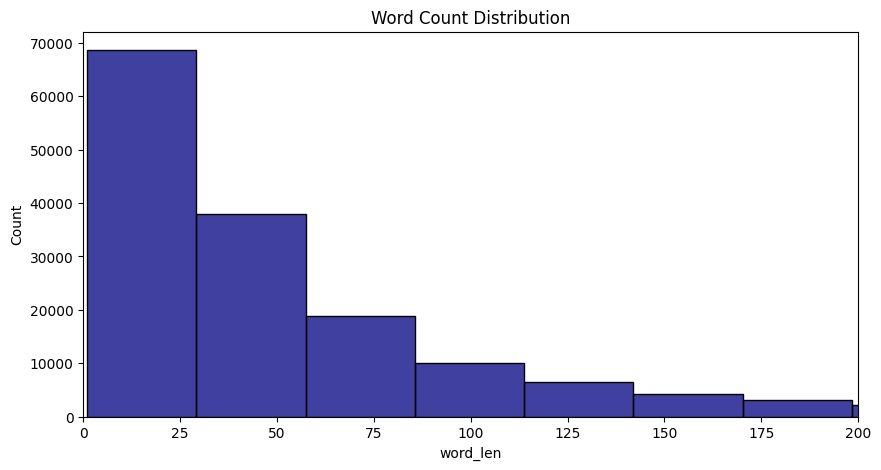

In [16]:
import numpy as np

df["char_len"] = df["comment_text"].str.len()
df["word_len"] = df["comment_text"].str.split().apply(len)

plt.figure(figsize=(10,5))
sns.histplot(df["word_len"], bins=50, color="navy")
plt.title("Word Count Distribution")
plt.xlim(0, 200)
plt.show()

/tmp/ipython-input-377471763.py:3: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(df[df.is_toxic==1]["word_len"], label="Toxic", shade=True)
/tmp/ipython-input-377471763.py:4: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(df[df.is_toxic==0]["word_len"], label="Non-Toxic", shade=True)


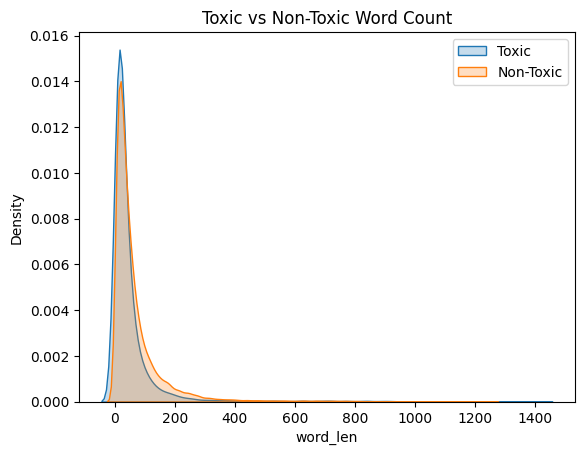

In [ ]:
df["is_toxic"] = df["toxic"]

sns.kdeplot(df[df.is_toxic==1]["word_len"], label="Toxic", shade=True)
sns.kdeplot(df[df.is_toxic==0]["word_len"], label="Non-Toxic", shade=True)
plt.title("Toxic vs Non-Toxic Word Count")
plt.legend()
plt.show()

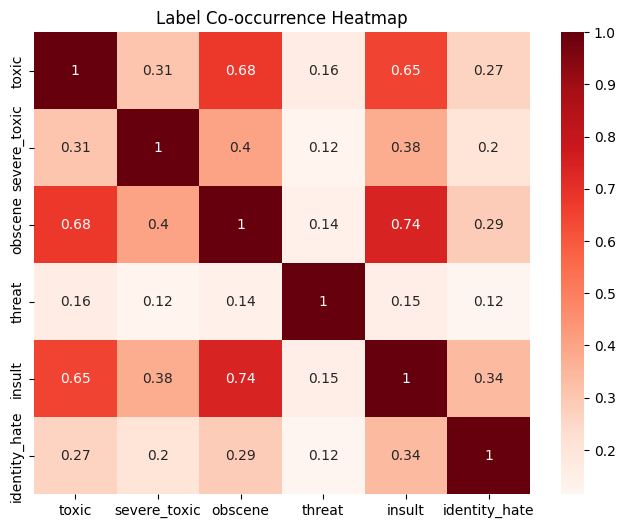

In [ ]:
corr = df[label_cols].corr()

plt.figure(figsize=(8,6))
sns.heatmap(corr, annot=True, cmap="Reds")
plt.title("Label Co-occurrence Heatmap")
plt.show()

In [17]:
from sklearn.feature_extraction.text import CountVectorizer

toxic_comments = df[df["toxic"]==1]["comment_text"]
clean_comments = df[df["toxic"]==0]["comment_text"]

vectorizer = CountVectorizer(stop_words="english", max_features=50)
tox_vec = vectorizer.fit_transform(toxic_comments)

sum_words = tox_vec.sum(axis=0)
words_freq = [(word, sum_words[0, idx]) for word, idx in vectorizer.vocabulary_.items()]
words_freq = sorted(words_freq, key=lambda x: x[1], reverse=True)

pd.DataFrame(words_freq[:20], columns=["word", "count"])

,word,count
0,fuck,9934
1,wikipedia,3678
2,shit,3622
3,like,3512
4,nigger,3300
5,fucking,3289
6,suck,3235
7,ass,2939
8,hate,2631
9,don,2569


In [18]:
clean_vec = vectorizer.fit_transform(clean_comments)

sum_words = clean_vec.sum(axis=0)
words_freq = [(word, sum_words[0, idx]) for word, idx in vectorizer.vocabulary_.items()]
words_freq = sorted(words_freq, key=lambda x: x[1], reverse=True)

pd.DataFrame(words_freq[:20], columns=["word", "count"])

,word,count
0,article,56267
1,wikipedia,44749
2,page,44313
3,talk,35692
4,just,25348
5,like,24496
6,don,20967
7,think,18848
8,edit,17351
9,know,16943


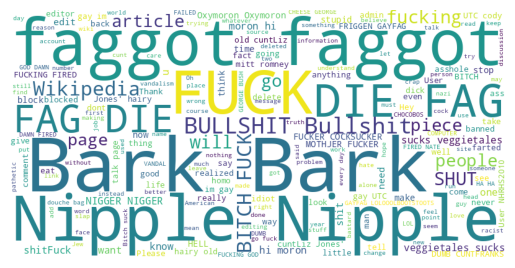

In [19]:
from wordcloud import WordCloud

text = " ".join(toxic_comments.sample(2000, random_state=42))
wc = WordCloud(width=800, height=400, background_color="white").generate(text)

plt.imshow(wc)
plt.axis("off")
plt.show()

In [20]:
def make_downsampled_df(df, label_cols, n_clean=20000, random_state=42):
    """Keep ALL toxic rows, randomly subsample clean rows."""
    clean_mask  = (df[label_cols].sum(axis=1) == 0)
    toxic_mask  = ~clean_mask

    clean_df = df[clean_mask]
    toxic_df = df[toxic_mask]

    # limit clean comments
    clean_sample = clean_df.sample(
        min(n_clean, len(clean_df)),
        random_state=random_state
    )

    df_down = pd.concat([clean_sample, toxic_df]).sample(frac=1, random_state=random_state)
    return df_down

df_down = make_downsampled_df(df, label_cols, n_clean=20000)
print("Original:", df.shape, "Downsampled:", df_down.shape)

Original: (159571, 11) Downsampled: (36225, 11)


In [21]:
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

STOPWORDS = set(stopwords.words("english"))
PUNCTUATION = set(string.punctuation)

def clean_text_series(x):
    """
    x: array-like of raw texts (Series or np.array).
    Returns cleaned text array (same shape).
    """
    def _clean(text):
        if not isinstance(text, str):
            return ""
        # lowercase
        text = text.lower()
        # remove punctuation
        text = re.sub(f"[{re.escape(string.punctuation)}]", " ", text)
        # remove extra spaces
        tokens = text.split()
        # remove stopwords
        tokens = [t for t in tokens if t not in STOPWORDS]
        return " ".join(tokens)

    return np.vectorize(_clean)(x)


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [10]:
def make_lr_pipeline(use_preprocessing=False):
    """
    Build a TF-IDF + OneVsRest(LogReg) pipeline, optionally with custom preprocessing.
    """
    if use_preprocessing:
        steps = [
            ("clean", FunctionTransformer(clean_text_series, validate=False)),
            ("tfidf", TfidfVectorizer(
                max_features=100_000,
                ngram_range=(1,2)   # unigrams + bigrams
            )),
            ("clf", OneVsRestClassifier(
                LogisticRegression(
                    C=1.0,
                    class_weight="balanced",
                    max_iter=200,
                    n_jobs=-1
                )
            ))
        ]
    else:
        steps = [
            ("tfidf", TfidfVectorizer(
                max_features=100_000,
                ngram_range=(1,2)
            )),
            ("clf", OneVsRestClassifier(
                LogisticRegression(
                    C=1.0,
                    class_weight="balanced",
                    max_iter=200,
                    n_jobs=-1
                )
            ))
        ]
    return Pipeline(steps)


def train_and_eval(df_in, use_preprocessing=False, desc=""):
    """
    Train + evaluate a LogReg baseline on given dataframe.
    Returns metrics dict.
    """
    X = df_in["comment_text"].fillna("")
    y = df_in[label_cols].values

    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42
    )

    pipe = make_lr_pipeline(use_preprocessing=use_preprocessing)
    print(f"\n===== Training Logistic Regression ({desc}) =====")
    pipe.fit(X_train, y_train)

    y_pred = pipe.predict(X_test)

    # multi-label accuracy = exact match accuracy (strict)
    acc = accuracy_score(y_test, y_pred)
    macro_f1 = f1_score(y_test, y_pred, average="macro")
    micro_f1 = f1_score(y_test, y_pred, average="micro")

    print(f"Accuracy (exact match): {acc:.4f}")
    print(f"Macro-F1:              {macro_f1:.4f}")
    print(f"Micro-F1:              {micro_f1:.4f}")

    return {
        "desc": desc,
        "accuracy": acc,
        "macro_f1": macro_f1,
        "micro_f1": micro_f1,
        "model": pipe
    }


In [ ]:
results = []

res_full_raw = train_and_eval(
    df, use_preprocessing=False,
    desc="FULL data, NO extra preprocessing"
)
results.append(res_full_raw)


res_full_clean = train_and_eval(
    df, use_preprocessing=True,
    desc="FULL data, WITH preprocessing"
)
results.append(res_full_clean)


df_down = make_downsampled_df(df, label_cols, n_clean=20000)

res_down_raw = train_and_eval(
    df_down, use_preprocessing=False,
    desc="DOWNSAMPLED, NO extra preprocessing"
)
results.append(res_down_raw)


res_down_clean = train_and_eval(
    df_down, use_preprocessing=True,
    desc="DOWNSAMPLED, WITH preprocessing"
)
results.append(res_down_clean)




===== Training Logistic Regression (FULL data, NO extra preprocessing) =====
Accuracy (exact match): 0.8825
Macro-F1:              0.5751
Micro-F1:              0.6916

===== Training Logistic Regression (FULL data, WITH preprocessing) =====
Accuracy (exact match): 0.8814
Macro-F1:              0.5563
Micro-F1:              0.6827

===== Training Logistic Regression (DOWNSAMPLED, NO extra preprocessing) =====
Accuracy (exact match): 0.6534
Macro-F1:              0.6335
Micro-F1:              0.7591

===== Training Logistic Regression (DOWNSAMPLED, WITH preprocessing) =====
Accuracy (exact match): 0.6553
Macro-F1:              0.6250
Micro-F1:              0.7578


In [ ]:
res_table = pd.DataFrame([
    {
        "Setting": r["desc"],
        "Accuracy": r["accuracy"],
        "Macro-F1": r["macro_f1"],
        "Micro-F1": r["micro_f1"]
    }
    for r in results
])

res_table


,Setting,Accuracy,Macro-F1,Micro-F1
0,"FULL data, NO extra preprocessing",0.882500,0.575123,0.691629
1,"FULL data, WITH preprocessing",0.881404,0.556254,0.682692
2,"DOWNSAMPLED, NO extra preprocessing",0.653416,0.633539,0.759075
3,"DOWNSAMPLED, WITH preprocessing",0.655349,0.624950,0.757838


from matplotlib import pyplot as plt
res_table['Accuracy'].plot(kind='hist', bins=20, title='Accuracy')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
res_table['Macro-F1'].plot(kind='hist', bins=20, title='Macro-F1')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
res_table['Micro-F1'].plot(kind='hist', bins=20, title='Micro-F1')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
res_table.groupby('Setting').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
res_table.plot(kind='scatter', x='Accuracy', y='Macro-F1', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
res_table.plot(kind='scatter', x='Macro-F1', y='Micro-F1', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
res_table['Accuracy'].plot(kind='line', figsize=(8, 4), title='Accuracy')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
res_table['Macro-F1'].plot(kind='line', figsize=(8, 4), title='Macro-F1')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
res_table['Micro-F1'].plot(kind='line', figsize=(8, 4), title='Micro-F1')
plt.gca().spines[['top', 'right']].set_visible(False)

<string>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.



from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(res_table['Setting'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(res_table, x='Accuracy', y='Setting', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

<string>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.



from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(res_table['Setting'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(res_table, x='Macro-F1', y='Setting', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

<string>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.



from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(res_table['Setting'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(res_table, x='Micro-F1', y='Setting', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

In [11]:
def make_tfidf_pipeline(model_type="lr", use_preprocessing=False):
    """
    model_type: "lr", "svm", or "nb"
    use_preprocessing: whether to apply custom cleaning (stopwords, punctuation removal)
    """
    steps = []

    if use_preprocessing:
        steps.append(
            ("clean", FunctionTransformer(clean_text_series, validate=False))
        )

    steps.append(
        ("tfidf", TfidfVectorizer(
            max_features=100_000,
            ngram_range=(1, 2),
            sublinear_tf=True  # small improvement often
        ))
    )

    if model_type == "lr":
        base_clf = LogisticRegression(
            C=1.0,
            class_weight="balanced",
            max_iter=200,
            n_jobs=-1
        )
    elif model_type == "svm":
        base_clf = LinearSVC(
            C=1.0,
            class_weight="balanced"
        )
    elif model_type == "nb":
        base_clf = MultinomialNB(
            alpha=0.5  # smoothing parameter to tune
        )
    else:
        raise ValueError("Unknown model_type: " + model_type)

    steps.append(
        ("clf", OneVsRestClassifier(base_clf))
    )

    return Pipeline(steps)


In [12]:
def train_and_eval_model(df_in, model_type="lr", use_preprocessing=False, desc=""):
    """
    Train + evaluate one model on df_in.
    Returns metrics dict.
    """
    X = df_in["comment_text"].fillna("")
    y = df_in[label_cols].values

    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42
    )

    pipe = make_tfidf_pipeline(model_type=model_type,
                               use_preprocessing=use_preprocessing)

    print(f"\n===== Training {model_type.upper()} ({desc}) =====")
    pipe.fit(X_train, y_train)

    y_pred = pipe.predict(X_test)

    acc      = accuracy_score(y_test, y_pred)
    macro_f1 = f1_score(y_test, y_pred, average="macro")
    micro_f1 = f1_score(y_test, y_pred, average="micro")

    print(f"Accuracy (exact match): {acc:.4f}")
    print(f"Macro-F1:              {macro_f1:.4f}")
    print(f"Micro-F1:              {micro_f1:.4f}")

    return {
        "model_type": model_type,
        "desc": desc,
        "accuracy": acc,
        "macro_f1": macro_f1,
        "micro_f1": micro_f1,
        "model": pipe
    }


In [ ]:
results_svm = []

# FULL data
results_svm.append(
    train_and_eval_model(df, model_type="svm",
                         use_preprocessing=False,
                         desc="SVM – FULL data, NO preprocessing")
)

results_svm.append(
    train_and_eval_model(df, model_type="svm",
                         use_preprocessing=True,
                         desc="SVM – FULL data, WITH preprocessing")
)

# DOWNSAMPLED data (df_down from earlier)
results_svm.append(
    train_and_eval_model(df_down, model_type="svm",
                         use_preprocessing=False,
                         desc="SVM – DOWNSAMPLED, NO preprocessing")
)

results_svm.append(
    train_and_eval_model(df_down, model_type="svm",
                         use_preprocessing=True,
                         desc="SVM – DOWNSAMPLED, WITH preprocessing")
)

pd.DataFrame([
    {
        "Setting": r["desc"],
        "Accuracy": r["accuracy"],
        "Macro-F1": r["macro_f1"],
        "Micro-F1": r["micro_f1"],
    } for r in results_svm
])



===== Training SVM (SVM – FULL data, NO preprocessing) =====
Accuracy (exact match): 0.9068
Macro-F1:              0.6146
Micro-F1:              0.7339

===== Training SVM (SVM – FULL data, WITH preprocessing) =====
Accuracy (exact match): 0.8973
Macro-F1:              0.5874
Micro-F1:              0.7148

===== Training SVM (SVM – DOWNSAMPLED, NO preprocessing) =====
Accuracy (exact match): 0.6849
Macro-F1:              0.6176
Micro-F1:              0.7716

===== Training SVM (SVM – DOWNSAMPLED, WITH preprocessing) =====
Accuracy (exact match): 0.6787
Macro-F1:              0.6244
Micro-F1:              0.7682


,Setting,Accuracy,Macro-F1,Micro-F1
0,"SVM – FULL data, NO preprocessing",0.906846,0.614584,0.733881
1,"SVM – FULL data, WITH preprocessing",0.897321,0.587391,0.714786
2,"SVM – DOWNSAMPLED, NO preprocessing",0.684886,0.617554,0.771553
3,"SVM – DOWNSAMPLED, WITH preprocessing",0.678675,0.624416,0.768179


In [ ]:
results_nb = []

# FULL
results_nb.append(
    train_and_eval_model(df, model_type="nb",
                         use_preprocessing=False,
                         desc="NB – FULL data, NO preprocessing")
)

results_nb.append(
    train_and_eval_model(df, model_type="nb",
                         use_preprocessing=True,
                         desc="NB – FULL data, WITH preprocessing")
)

# DOWNSAMPLED
results_nb.append(
    train_and_eval_model(df_down, model_type="nb",
                         use_preprocessing=False,
                         desc="NB – DOWNSAMPLED, NO preprocessing")
)

results_nb.append(
    train_and_eval_model(df_down, model_type="nb",
                         use_preprocessing=True,
                         desc="NB – DOWNSAMPLED, WITH preprocessing")
)

pd.DataFrame([
    {
        "Setting": r["desc"],
        "Accuracy": r["accuracy"],
        "Macro-F1": r["macro_f1"],
        "Micro-F1": r["micro_f1"],
    } for r in results_nb
])



===== Training NB (NB – FULL data, NO preprocessing) =====
Accuracy (exact match): 0.9113
Macro-F1:              0.3301
Micro-F1:              0.5781

===== Training NB (NB – FULL data, WITH preprocessing) =====
Accuracy (exact match): 0.9090
Macro-F1:              0.2997
Micro-F1:              0.5234

===== Training NB (NB – DOWNSAMPLED, NO preprocessing) =====
Accuracy (exact match): 0.6694
Macro-F1:              0.3522
Micro-F1:              0.6878

===== Training NB (NB – DOWNSAMPLED, WITH preprocessing) =====
Accuracy (exact match): 0.6616
Macro-F1:              0.3375
Micro-F1:              0.6710


,Setting,Accuracy,Macro-F1,Micro-F1
0,"NB – FULL data, NO preprocessing",0.911327,0.330099,0.578137
1,"NB – FULL data, WITH preprocessing",0.909008,0.299693,0.523381
2,"NB – DOWNSAMPLED, NO preprocessing",0.669427,0.352243,0.687758
3,"NB – DOWNSAMPLED, WITH preprocessing",0.661560,0.337493,0.670998


In [ ]:
import pandas as pd

df_all = pd.DataFrame([
    {
        "Model": r.get("model_type", "lr").upper(),
        "Setting": r["desc"],
        "Accuracy": r["accuracy"],
        "Macro-F1": r["macro_f1"],
        "Micro-F1": r["micro_f1"]
    }
    for r in results + results_svm + results_nb
])

df_all


,Model,Setting,Accuracy,Macro-F1,Micro-F1
0,LR,"FULL data, NO extra preprocessing",0.882500,0.575123,0.691629
1,LR,"FULL data, WITH preprocessing",0.881404,0.556254,0.682692
2,LR,"DOWNSAMPLED, NO extra preprocessing",0.653416,0.633539,0.759075
3,LR,"DOWNSAMPLED, WITH preprocessing",0.655349,0.624950,0.757838
4,SVM,"SVM – FULL data, NO preprocessing",0.906846,0.614584,0.733881
5,SVM,"SVM – FULL data, WITH preprocessing",0.897321,0.587391,0.714786
6,SVM,"SVM – DOWNSAMPLED, NO preprocessing",0.684886,0.617554,0.771553
7,SVM,"SVM – DOWNSAMPLED, WITH preprocessing",0.678675,0.624416,0.768179
8,NB,"NB – FULL data, NO preprocessing",0.911327,0.330099,0.578137
9,NB,"NB – FULL data, WITH preprocessing",0.909008,0.299693,0.523381


In [ ]:
df_all["ShortSetting"] = (
    df_all["Setting"]
    .str.replace(" – ", " - ", regex=False)
    .str.replace("FULL data", "Full", regex=False)
    .str.replace("DOWNSAMPLED", "Downsampled", regex=False)
    .str.replace("NO preprocessing", "No-Prep", regex=False)
    .str.replace("WITH preprocessing", "Prep", regex=False)
)


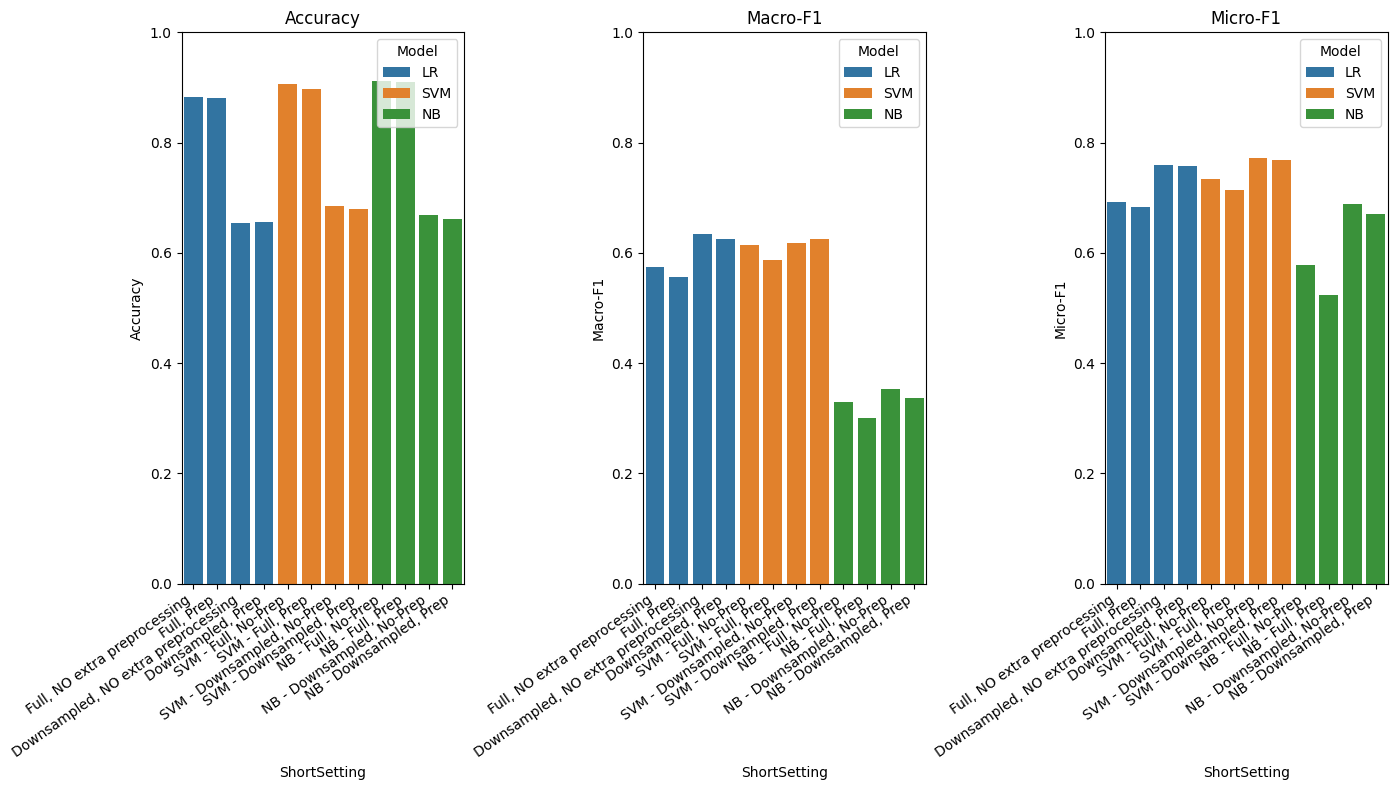

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

metrics = ["Accuracy", "Macro-F1", "Micro-F1"]

plt.figure(figsize=(14, 8))
for i, metric in enumerate(metrics, 1):
    plt.subplot(1, 3, i)
    sns.barplot(data=df_all, x="ShortSetting", y=metric, hue="Model")
    plt.xticks(rotation=35, ha="right")
    plt.title(metric)
    plt.ylim(0, 1)
    plt.legend(title="Model")

plt.tight_layout()
plt.show()


In [ ]:
# Experimenting with different C and alpha values

# ================================
# 1. Imports
# ================================
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import accuracy_score, f1_score

from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import MultinomialNB

# 2. Train/val split (full data)
X = df["comment_text"].fillna("")
y = df[label_cols].values   # shape (n_samples, 6)

X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# 3. Helper: build pipeline
def make_tfidf_pipeline(model_type="lr", C=1.0, alpha=0.5):
    """
    model_type: "lr", "svm", or "nb"
    C:         regularization for LR / SVM
    alpha:     smoothing for NB
    """
    steps = []

    # TF-IDF (no extra preprocessing here)
    steps.append((
        "tfidf",
        TfidfVectorizer(
            max_features=100_000,
            ngram_range=(1, 2),
            sublinear_tf=True
        )
    ))

    # Base classifier
    if model_type == "lr":
        base = LogisticRegression(
            C=C,
            class_weight="balanced",
            max_iter=200
        )
    elif model_type == "svm":
        base = LinearSVC(
            C=C,
            class_weight="balanced"
        )
    elif model_type == "nb":
        base = MultinomialNB(alpha=alpha)
    else:
        raise ValueError("Unknown model_type")

    steps.append(("clf", OneVsRestClassifier(base)))
    return Pipeline(steps)

# 4. Helper: fit + evaluate
def eval_pipeline(pipe):
    pipe.fit(X_train, y_train)
    y_pred = pipe.predict(X_val)
    return {
        "accuracy": accuracy_score(y_val, y_pred),
        "macro_f1": f1_score(y_val, y_pred, average="macro", zero_division=0),
        "micro_f1": f1_score(y_val, y_pred, average="micro", zero_division=0)
    }

# 5. Grids
C_values     = [0.1, 0.5, 1, 2, 5]
alpha_values = [0.1, 0.5, 1, 2, 5]

# 6. Tune Logistic Regression (C)
lr_tuning = []
for C in C_values:
    pipe = make_tfidf_pipeline(model_type="lr", C=C)
    res = eval_pipeline(pipe)
    res["C"] = C
    lr_tuning.append(res)

lr_tuning_df = pd.DataFrame(lr_tuning)
print("=== Logistic Regression tuning (full, no-prep) ===")
display(lr_tuning_df)

# 7. Tune SVM (C)
svm_tuning = []
for C in C_values:
    pipe = make_tfidf_pipeline(model_type="svm", C=C)
    res = eval_pipeline(pipe)
    res["C"] = C
    svm_tuning.append(res)

svm_tuning_df = pd.DataFrame(svm_tuning)
print("=== SVM tuning (full, no-prep) ===")
display(svm_tuning_df)

# 8. Tune Naive Bayes (alpha)
nb_tuning = []
for a in alpha_values:
    pipe = make_tfidf_pipeline(model_type="nb", alpha=a)
    res = eval_pipeline(pipe)
    res["alpha"] = a
    nb_tuning.append(res)

nb_tuning_df = pd.DataFrame(nb_tuning)
print("=== Naive Bayes tuning (full, no-prep) ===")
display(nb_tuning_df)



=== Logistic Regression tuning (full, no-prep) ===


,accuracy,macro_f1,micro_f1,C
0,0.852044,0.486074,0.604468,0.1
1,0.873664,0.553588,0.671063,0.5
2,0.882438,0.577601,0.693280,1.0
3,0.889425,0.592246,0.710594,2.0
4,0.896099,0.609979,0.726260,5.0


/usr/local/lib/python3.12/dist-packages/sklearn/svm/_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


=== SVM tuning (full, no-prep) ===


,accuracy,macro_f1,micro_f1,C
0,0.887326,0.590854,0.707984,0.1
1,0.903306,0.616037,0.734366,0.5
2,0.906846,0.614584,0.733881,1.0
3,0.909165,0.606029,0.729121,2.0
4,0.907755,0.592305,0.716296,5.0


=== Naive Bayes tuning (full, no-prep) ===


,accuracy,macro_f1,micro_f1,alpha
0,0.909510,0.468271,0.664812,0.1
1,0.911327,0.330099,0.578137,0.5
2,0.906314,0.247055,0.460637,1.0
3,0.902303,0.162807,0.319603,2.0
4,0.899264,0.075031,0.151032,5.0


In [14]:
!pip install fasttext

import fasttext
import pandas as pd
import numpy as np

# Create multi-label FastText format: __label__toxic __label__insult  comment text
def make_fasttext_file(df, path):
    with open(path, "w", encoding="utf-8") as f:
        for _, row in df.iterrows():
            labels = []
            for col in label_cols:
                if row[col] == 1:
                    labels.append(f"__label__{col}")
            if len(labels) == 0:
                labels.append("__label__clean")

            line = " ".join(labels) + " " + row["comment_text"].replace("\n", " ")
            f.write(line + "\n")

# Train/val split
train_df, val_df = train_test_split(df, test_size=0.2, random_state=42)

make_fasttext_file(train_df, "ft_train.txt")
make_fasttext_file(val_df, "ft_val.txt")

# Train FastText model
ft_model = fasttext.train_supervised(
    input="ft_train.txt",
    lr=0.5,
    epoch=10,
    wordNgrams=2,
    dim=100
)

# Evaluation
ft_model.test("ft_val.txt")


(31915, 0.9481121729594235, 0.8465239893691425)

In [17]:
import numpy as np
from sklearn.metrics import accuracy_score, f1_score

# 1. Ground-truth labels
y_true = val_df[label_cols].values  # (n_samples, 6)

# 2. Clean texts for FastText (no newlines)
texts = [
    (t.replace("\n", " ") if isinstance(t, str) else "")
    for t in val_df["comment_text"].tolist()
]

# 3. FastText predictions
# k=-1 -> consider all labels; threshold=0.5 -> only labels above this prob
pred_labels, pred_probs = ft_model.predict(texts, k=-1, threshold=0.5)

# 4. Convert FastText label strings -> multi-hot matrix
label_to_idx = {lab: i for i, lab in enumerate(label_cols)}
y_pred = np.zeros_like(y_true, dtype=int)

for i, labels in enumerate(pred_labels):
    for lab in labels:
        if lab == "__label__clean":
            continue
        name = lab.replace("__label__", "")
        if name in label_to_idx:
            y_pred[i, label_to_idx[name]] = 1

# 5. Metrics
exact_match_acc = (y_true == y_pred).all(axis=1).mean()
macro_f1 = f1_score(y_true, y_pred, average="macro", zero_division=0)
micro_f1 = f1_score(y_true, y_pred, average="micro", zero_division=0)

print("FastText - Exact-match Accuracy:", exact_match_acc)
print("FastText - Macro-F1:", macro_f1)
print("FastText - Micro-F1:", micro_f1)


FastText - Exact-match Accuracy: 0.9003603321322262
FastText - Macro-F1: 0.11920246669852845
FastText - Micro-F1: 0.27737397420867527


In [19]:
import fasttext
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score

# ===== 1. Build downsampled dataset for FastText =====

N_CLEAN = 20000  # number of clean comments to keep

# "clean" = all label cols are 0
is_clean = (df[label_cols].sum(axis=1) == 0)
df_clean = df[is_clean]
df_toxic = df[~is_clean]

df_clean_sample = df_clean.sample(n=N_CLEAN, random_state=42)
df_down_ft = pd.concat([df_clean_sample, df_toxic], axis=0)
df_down_ft = df_down_ft.sample(frac=1, random_state=42).reset_index(drop=True)  # shuffle

print("Downsampled FastText dataset size:", df_down_ft.shape)

# ===== 2. Train/val split on the downsampled data =====

train_df_ft, val_df_ft = train_test_split(
    df_down_ft, test_size=0.2, random_state=42
)

# ===== 3. Helper to create FastText formatted files =====

def make_fasttext_file(df_in, path):
    with open(path, "w", encoding="utf-8") as f:
        for _, row in df_in.iterrows():
            labels = []
            for col in label_cols:
                if row[col] == 1:
                    labels.append(f"__label__{col}")
            if len(labels) == 0:
                labels.append("__label__clean")

            text = str(row["comment_text"]).replace("\n", " ")
            line = " ".join(labels) + " " + text
            f.write(line + "\n")

make_fasttext_file(train_df_ft, "ft_train.txt")
make_fasttext_file(val_df_ft, "ft_val.txt")

# ===== 4. Train FastText on the downsampled data =====

ft_model = fasttext.train_supervised(
    input="ft_train.txt",
    lr=0.5,
    epoch=10,
    wordNgrams=2,
    dim=100
)

print("FastText train stats (internal):")
print(ft_model.test("ft_train.txt"))
print("FastText val stats (internal):")
print(ft_model.test("ft_val.txt"))

# ===== 5. Evaluate with Accuracy / Macro-F1 / Micro-F1 =====

y_true = val_df_ft[label_cols].values  # (n_samples, 6)

texts = [
    (t.replace("\n", " ") if isinstance(t, str) else "")
    for t in val_df_ft["comment_text"].tolist()
]

# k=-1 -> all labels; threshold=0.5 -> labels with prob >= 0.5
pred_labels, pred_probs = ft_model.predict(texts, k=-1, threshold=0.5)

label_to_idx = {lab: i for i, lab in enumerate(label_cols)}
y_pred = np.zeros_like(y_true, dtype=int)

for i, labels in enumerate(pred_labels):
    for lab in labels:
        if lab == "__label__clean":
            continue
        name = lab.replace("__label__", "")
        if name in label_to_idx:
            y_pred[i, label_to_idx[name]] = 1

exact_match_acc = (y_true == y_pred).all(axis=1).mean()
macro_f1 = f1_score(y_true, y_pred, average="macro", zero_division=0)
micro_f1 = f1_score(y_true, y_pred, average="micro", zero_division=0)

print("FastText (downsampled) - Exact-match Accuracy:", exact_match_acc)
print("FastText (downsampled) - Macro-F1:", macro_f1)
print("FastText (downsampled) - Micro-F1:", micro_f1)


Downsampled FastText dataset size: (36225, 8)
FastText train stats (internal):
(28980, 0.9841959972394755, 0.6455862381167949)
FastText val stats (internal):
(7245, 0.852864044168392, 0.5659461439824144)
FastText (downsampled) - Exact-match Accuracy: 0.6150448585231194
FastText (downsampled) - Macro-F1: 0.1514672849040953
FastText (downsampled) - Micro-F1: 0.37918970770793364


In [34]:
!pip install transformers datasets accelerate

import torch
from torch.utils.data import Dataset, DataLoader
from transformers import BertTokenizer, BertForSequenceClassification
from torch.optim import AdamW


device = "cuda" if torch.cuda.is_available() else "cpu"
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

class ToxicDataset(Dataset):
    def __init__(self, texts, labels):
        self.texts = texts.tolist()
        self.labels = torch.tensor(labels.values, dtype=torch.float)

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        enc = tokenizer(
            self.texts[idx],
            truncation=True,
            padding="max_length",
            max_length=128,
            return_tensors="pt"
        )
        return {
            "input_ids": enc["input_ids"].squeeze(),
            "attention_mask": enc["attention_mask"].squeeze(),
            "labels": self.labels[idx]
        }

# train_df, val_df = train_test_split(df, test_size=0.1, random_state=42)
# train_ds = ToxicDataset(train_df["comment_text"], train_df[label_cols])
# val_ds   = ToxicDataset(val_df["comment_text"], val_df[label_cols])

# train_loader = DataLoader(train_ds, batch_size=16, shuffle=True)
# val_loader   = DataLoader(val_ds, batch_size=16)


In [28]:
print("df columns:", df.columns.tolist())
print("train_df columns:", train_df.columns.tolist())
print("train_df_down columns:", train_df_down.columns.tolist())


df columns: ['id', 'comment_text', 'toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate', 'char_len', 'word_len', 'num_labels']
train_df columns: ['id', 'comment_text', 'toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate', 'char_len', 'word_len', 'num_labels']
train_df_down columns: ['id', 'comment_text', 'toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate', 'char_len', 'word_len', 'num_labels']


In [5]:
from transformers import get_linear_schedule_with_warmup

In [22]:
model = BertForSequenceClassification.from_pretrained(
    "bert-base-uncased",
    num_labels=len(label_cols),
    problem_type="multi_label_classification"
).to(device)

optimizer = AdamW(model.parameters(), lr=2e-5)

for epoch in range(3):  # keep small for speed
    model.train()
    for batch in train_loader:
        optimizer.zero_grad()

        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels = batch["labels"].to(device)

        outputs = model(
            input_ids=input_ids,
            attention_mask=attention_mask,
            labels=labels
        )
        loss = outputs.loss
        loss.backward()
        optimizer.step()

    print(f"Epoch {epoch+1} Loss:", loss.item())


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1 Loss: 0.014106721617281437
Epoch 2 Loss: 0.013395274057984352
Epoch 3 Loss: 0.04545287787914276


In [23]:
from sklearn.metrics import f1_score, accuracy_score

model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for batch in val_loader:
        logits = model(
            batch["input_ids"].to(device),
            batch["attention_mask"].to(device)
        ).logits

        preds = (torch.sigmoid(logits) > 0.5).int().cpu()
        labels = batch["labels"]

        all_preds.append(preds)
        all_labels.append(labels)

all_preds = torch.cat(all_preds).numpy()
all_labels = torch.cat(all_labels).numpy()

print("BERT Macro-F1:", f1_score(all_labels, all_preds, average="macro"))
print("BERT Micro-F1:", f1_score(all_labels, all_preds, average="micro"))


BERT Macro-F1: 0.6672953844053796
BERT Micro-F1: 0.7886582870505701


In [25]:
from sklearn.metrics import f1_score, accuracy_score, classification_report
import numpy as np

# all_labels, all_preds are numpy arrays (n_samples, 6)

# exact-match accuracy (all labels correct)
exact_match = (all_labels == all_preds).all(axis=1).mean()

# simple per-label accuracy (per position)
per_label_acc = (all_labels == all_preds).mean()

# sample-based F1 (averages F1 over samples)
sample_f1 = f1_score(all_labels, all_preds, average="samples", zero_division=0)

# per-label F1
per_label_f1 = f1_score(all_labels, all_preds, average=None, zero_division=0)

print("BERT Exact-match Accuracy:", exact_match)
print("BERT Per-label Accuracy:", per_label_acc)
print("BERT Sample-based F1:", sample_f1)
print("BERT Per-label F1:", per_label_f1)

# optional: nice text report
print("\nPer-label classification report:")
print(classification_report(all_labels, all_preds, target_names=label_cols, zero_division=0))


BERT Exact-match Accuracy: 0.9288757989723023
BERT Per-label Accuracy: 0.984897856874295
BERT Sample-based F1: 0.06844967046433395
BERT Per-label F1: [0.83282879 0.45421245 0.82807018 0.55263158 0.76685934 0.56916996]

Per-label classification report:
               precision    recall  f1-score   support

        toxic       0.83      0.84      0.83      1480
 severe_toxic       0.50      0.42      0.45       148
      obscene       0.81      0.85      0.83       836
       threat       0.54      0.57      0.55        37
       insult       0.78      0.75      0.77       791
identity_hate       0.68      0.49      0.57       147

    micro avg       0.79      0.78      0.79      3439
    macro avg       0.69      0.65      0.67      3439
 weighted avg       0.79      0.78      0.79      3439
  samples avg       0.07      0.07      0.07      3439



In [38]:
print(df.head()[["comment_text"] + label_cols])
print("Shape:", df.shape)
print(label_cols)

                                        comment_text  toxic  severe_toxic  \
0  Explanation\nWhy the edits made under my usern...      0             0   
1  D'aww! He matches this background colour I'm s...      0             0   
2  Hey man, I'm really not trying to edit war. It...      0             0   
3  "\nMore\nI can't make any real suggestions on ...      0             0   
4  You, sir, are my hero. Any chance you remember...      0             0   

   obscene  threat  insult  identity_hate  
0        0       0       0              0  
1        0       0       0              0  
2        0       0       0              0  
3        0       0       0              0  
4        0       0       0              0  
Shape: (159571, 11)
['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']


In [44]:
# Binary indicator: any toxicity vs clean, used just for stratification
any_toxic = (df[label_cols].sum(axis=1) > 0).astype(int)

train_df, val_df = train_test_split(
    df,
    test_size=0.2,
    random_state=42,
    stratify=any_toxic
)

print("Train shape:", train_df.shape, "Val shape:", val_df.shape)

def make_downsampled_df(df_in, label_cols, n_clean=20000, random_state=42):
    """Keep ALL toxic rows, randomly subsample clean rows."""
    clean_mask = (df_in[label_cols].sum(axis=1) == 0)
    toxic_mask = ~clean_mask

    clean_df = df_in[clean_mask]
    toxic_df = df_in[toxic_mask]

    clean_sample = clean_df.sample(
        min(n_clean, len(clean_df)),
        random_state=random_state
    )

    df_down = pd.concat([clean_sample, toxic_df]).sample(frac=1, random_state=random_state)
    return df_down

train_df_down = make_downsampled_df(train_df, label_cols, n_clean=20000)
print("Original train:", train_df.shape, "Downsampled train:", train_df_down.shape)

Train shape: (127656, 8) Val shape: (31915, 8)
Original train: (127656, 8) Downsampled train: (32980, 8)


In [41]:
import numpy as np
import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import BertTokenizerFast, BertForSequenceClassification
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, accuracy_score

In [50]:
tokenizer = BertTokenizerFast.from_pretrained("bert-base-uncased")

class ToxicDataset(Dataset):
    def __init__(self, df, tokenizer, label_cols, max_length=128):
        self.texts = df["comment_text"].astype(str).tolist()
        self.labels = df[label_cols].values.astype("float32")
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        labels = self.labels[idx]

        enc = self.tokenizer(
            text,
            truncation=True,
            padding="max_length",
            max_length=self.max_length,
            return_tensors="pt"
        )

        return {
            "input_ids": enc["input_ids"].squeeze(0),
            "attention_mask": enc["attention_mask"].squeeze(0),
            "labels": torch.tensor(labels, dtype=torch.float)
        }

# Full-data loaders
train_dataset_full = ToxicDataset(train_df,      tokenizer, label_cols, max_length=128)
val_dataset        = ToxicDataset(val_df,        tokenizer, label_cols, max_length=128)

train_loader_full  = DataLoader(train_dataset_full, batch_size=256, shuffle=True)
val_loader         = DataLoader(val_dataset,       batch_size=256, shuffle=False)

# Downsampled-data loader
train_dataset_down = ToxicDataset(train_df_down,  tokenizer, label_cols, max_length=128)
train_loader_down  = DataLoader(train_dataset_down, batch_size=256, shuffle=True)


In [51]:
def train_and_eval_bert(train_loader, val_loader, n_epochs=3, lr=2e-5, run_name=""):
    model = BertForSequenceClassification.from_pretrained(
        "bert-base-uncased",
        num_labels=len(label_cols),
        problem_type="multi_label_classification"
    ).to(device)

    optimizer = torch.optim.AdamW(model.parameters(), lr=lr)

    # ---- Training ----
    for epoch in range(n_epochs):
        model.train()
        total_loss = 0.0
        for batch in train_loader:
            optimizer.zero_grad()
            outputs = model(
                input_ids=batch["input_ids"].to(device),
                attention_mask=batch["attention_mask"].to(device),
                labels=batch["labels"].to(device)
            )
            loss = outputs.loss
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        print(f"[{run_name}] Epoch {epoch+1}/{n_epochs} - Train loss: {total_loss/len(train_loader):.4f}")

    # ---- Evaluation ----
    model.eval()
    all_logits = []
    all_labels = []
    with torch.no_grad():
        for batch in val_loader:
            outputs = model(
                input_ids=batch["input_ids"].to(device),
                attention_mask=batch["attention_mask"].to(device)
            )
            logits = outputs.logits
            all_logits.append(logits.cpu())
            all_labels.append(batch["labels"])

    all_logits = torch.cat(all_logits).numpy()
    all_labels = torch.cat(all_labels).numpy()

    # sigmoid + threshold 0.5
    probs = 1 / (1 + np.exp(-all_logits))
    preds = (probs > 0.5).astype(int)

    macro_f1 = f1_score(all_labels, preds, average="macro", zero_division=0)
    micro_f1 = f1_score(all_labels, preds, average="micro", zero_division=0)
    exact_match = (all_labels == preds).all(axis=1).mean()
    per_label_acc = (all_labels == preds).mean()

    print(f"[{run_name}] Macro-F1: {macro_f1:.4f}")
    print(f"[{run_name}] Micro-F1: {micro_f1:.4f}")
    print(f"[{run_name}] Exact-match Accuracy: {exact_match:.4f}")
    print(f"[{run_name}] Per-label Accuracy: {per_label_acc:.4f}")

    metrics = {
        "macro_f1": macro_f1,
        "micro_f1": micro_f1,
        "exact_match": exact_match,
        "per_label_acc": per_label_acc
    }
    return model, metrics


In [47]:
print("\n===== BERT on DOWNSAMPLED training data =====")
bert_down, metrics_down = train_and_eval_bert(
    train_loader_down,
    val_loader,
    n_epochs=3,
    lr=2e-5,
    run_name="BERT-DOWNSAMPLED"
)

print("\nSummary:")
print("DOWNSAMPLED:", metrics_down)


===== BERT on DOWNSAMPLED training data =====


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


[BERT-DOWNSAMPLED] Epoch 1/3 - Train loss: 0.1491
[BERT-DOWNSAMPLED] Epoch 2/3 - Train loss: 0.1058
[BERT-DOWNSAMPLED] Epoch 3/3 - Train loss: 0.0865
[BERT-DOWNSAMPLED] Macro-F1: 0.6659
[BERT-DOWNSAMPLED] Micro-F1: 0.7552
[BERT-DOWNSAMPLED] Exact-match Accuracy: 0.9032
[BERT-DOWNSAMPLED] Per-label Accuracy: 0.9806

Summary:
DOWNSAMPLED: {'macro_f1': 0.6659288978032949, 'micro_f1': 0.7552281993949757, 'exact_match': np.float64(0.9031803227322576), 'per_label_acc': np.float64(0.9805629536790433)}


In [48]:
print("\n===== BERT on DOWNSAMPLED training data =====")
bert_down, metrics_down = train_and_eval_bert(
    train_loader_down,
    val_loader,
    n_epochs=6,
    lr=2e-5,
    run_name="BERT-DOWNSAMPLED"
)

print("\nSummary:")
print("DOWNSAMPLED:", metrics_down)


===== BERT on DOWNSAMPLED training data =====


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


[BERT-DOWNSAMPLED] Epoch 1/6 - Train loss: 0.1516
[BERT-DOWNSAMPLED] Epoch 2/6 - Train loss: 0.1068
[BERT-DOWNSAMPLED] Epoch 3/6 - Train loss: 0.0872
[BERT-DOWNSAMPLED] Epoch 4/6 - Train loss: 0.0690
[BERT-DOWNSAMPLED] Epoch 5/6 - Train loss: 0.0505
[BERT-DOWNSAMPLED] Epoch 6/6 - Train loss: 0.0372
[BERT-DOWNSAMPLED] Macro-F1: 0.6385
[BERT-DOWNSAMPLED] Micro-F1: 0.7371
[BERT-DOWNSAMPLED] Exact-match Accuracy: 0.8971
[BERT-DOWNSAMPLED] Per-label Accuracy: 0.9791

Summary:
DOWNSAMPLED: {'macro_f1': 0.6385432308490872, 'micro_f1': 0.7371259454126932, 'exact_match': np.float64(0.8971330095566348), 'per_label_acc': np.float64(0.9791268473549533)}


In [52]:
# retraining BERT with higher batch size (256)
print("===== BERT on FULL training data =====")
bert_full, metrics_full = train_and_eval_bert(
    train_loader_full,
    val_loader,
    n_epochs=3,
    lr=2e-5,
    run_name="BERT-FULL"
)

print("\n===== BERT on DOWNSAMPLED training data =====")
bert_down, metrics_down = train_and_eval_bert(
    train_loader_down,
    val_loader,
    n_epochs=6,
    lr=2e-5,
    run_name="BERT-DOWNSAMPLED"
)

print("\nSummary:")
print("FULL:       ", metrics_full)
print("DOWNSAMPLED:", metrics_down)


===== BERT on FULL training data =====


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


[BERT-FULL] Epoch 1/3 - Train loss: 0.0890
[BERT-FULL] Epoch 2/3 - Train loss: 0.0408
[BERT-FULL] Epoch 3/3 - Train loss: 0.0343
[BERT-FULL] Macro-F1: 0.6432
[BERT-FULL] Micro-F1: 0.7939
[BERT-FULL] Exact-match Accuracy: 0.9289
[BERT-FULL] Per-label Accuracy: 0.9854

===== BERT on DOWNSAMPLED training data =====


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


[BERT-DOWNSAMPLED] Epoch 1/6 - Train loss: 0.2576
[BERT-DOWNSAMPLED] Epoch 2/6 - Train loss: 0.1387
[BERT-DOWNSAMPLED] Epoch 3/6 - Train loss: 0.1175
[BERT-DOWNSAMPLED] Epoch 4/6 - Train loss: 0.1032
[BERT-DOWNSAMPLED] Epoch 5/6 - Train loss: 0.0921
[BERT-DOWNSAMPLED] Epoch 6/6 - Train loss: 0.0809
[BERT-DOWNSAMPLED] Macro-F1: 0.6359
[BERT-DOWNSAMPLED] Micro-F1: 0.7522
[BERT-DOWNSAMPLED] Exact-match Accuracy: 0.9029
[BERT-DOWNSAMPLED] Per-label Accuracy: 0.9805

Summary:
FULL:        {'macro_f1': 0.6432337806825229, 'micro_f1': 0.7938863987067382, 'exact_match': np.float64(0.9289049036503212), 'per_label_acc': np.float64(0.9853517154942817)}
DOWNSAMPLED: {'macro_f1': 0.6359062263380774, 'micro_f1': 0.7522059311351423, 'exact_match': np.float64(0.9028983236722544), 'per_label_acc': np.float64(0.9804950650164499)}


In [58]:
import numpy as np
import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader
from torch.optim import AdamW
from transformers import RobertaTokenizerFast, RobertaForSequenceClassification
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score

tokenizer = RobertaTokenizerFast.from_pretrained("roberta-base")

class ToxicDataset(Dataset):
    def __init__(self, df, tokenizer, label_cols, max_length=128):
        self.texts = df["comment_text"].astype(str).tolist()
        self.labels = df[label_cols].values.astype("float32")
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        labels = self.labels[idx]

        enc = self.tokenizer(
            text,
            truncation=True,
            padding="max_length",
            max_length=self.max_length,
            return_tensors="pt"
        )

        return {
            "input_ids": enc["input_ids"].squeeze(0),
            "attention_mask": enc["attention_mask"].squeeze(0),
            "labels": torch.tensor(labels, dtype=torch.float)
        }

BATCH_TRAIN = 256   # you can change this
BATCH_VAL   = 256

train_dataset_full = ToxicDataset(train_df,      tokenizer, label_cols, max_length=128)
train_dataset_down = ToxicDataset(train_df_down, tokenizer, label_cols, max_length=128)
val_dataset        = ToxicDataset(val_df,        tokenizer, label_cols, max_length=128)

train_loader_full  = DataLoader(train_dataset_full, batch_size=BATCH_TRAIN, shuffle=True, num_workers=2)
train_loader_down  = DataLoader(train_dataset_down, batch_size=BATCH_TRAIN, shuffle=True, num_workers=2)
val_loader         = DataLoader(val_dataset,       batch_size=BATCH_VAL,   shuffle=False, num_workers=2)

print("Full train batches:", len(train_loader_full))
print("Down train batches:", len(train_loader_down))
print("Val batches:", len(val_loader))

Full train batches: 499
Down train batches: 129
Val batches: 125


In [59]:
def train_and_eval_roberta(train_loader, val_loader, label_cols, n_epochs=3, lr=2e-5, run_name=""):
    model = RobertaForSequenceClassification.from_pretrained(
        "roberta-base",
        num_labels=len(label_cols),
        problem_type="multi_label_classification"
    ).to(device)

    optimizer = AdamW(model.parameters(), lr=lr)

    # ---- Train ----
    for epoch in range(n_epochs):
        model.train()
        total_loss = 0.0
        for batch in train_loader:
            optimizer.zero_grad()
            outputs = model(
                input_ids=batch["input_ids"].to(device),
                attention_mask=batch["attention_mask"].to(device),
                labels=batch["labels"].to(device)
            )
            loss = outputs.loss
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

        print(f"[{run_name}] Epoch {epoch+1}/{n_epochs} Train loss: {total_loss/len(train_loader):.4f}")

    # ---- Eval ----
    model.eval()
    all_logits = []
    all_labels = []
    with torch.no_grad():
        for batch in val_loader:
            outputs = model(
                input_ids=batch["input_ids"].to(device),
                attention_mask=batch["attention_mask"].to(device)
            )
            all_logits.append(outputs.logits.cpu())
            all_labels.append(batch["labels"])

    all_logits = torch.cat(all_logits).numpy()
    all_labels = torch.cat(all_labels).numpy()

    probs = 1 / (1 + np.exp(-all_logits))
    preds = (probs > 0.5).astype(int)

    macro_f1 = f1_score(all_labels, preds, average="macro", zero_division=0)
    micro_f1 = f1_score(all_labels, preds, average="micro", zero_division=0)
    exact_match = (all_labels == preds).all(axis=1).mean()
    per_label_acc = (all_labels == preds).mean()

    print(f"[{run_name}] Macro-F1: {macro_f1:.4f}")
    print(f"[{run_name}] Micro-F1: {micro_f1:.4f}")
    print(f"[{run_name}] Exact-match: {exact_match:.4f}")
    print(f"[{run_name}] Per-label Acc: {per_label_acc:.4f}")

    metrics = {
        "macro_f1": float(macro_f1),
        "micro_f1": float(micro_f1),
        "exact_match": float(exact_match),
        "per_label_acc": float(per_label_acc),
    }
    return model, metrics

In [60]:
print("\n===== RoBERTa on FULL training data =====")
roberta_full, metrics_roberta_full = train_and_eval_roberta(
    train_loader_full,
    val_loader,
    label_cols=label_cols,
    n_epochs=3,
    lr=2e-5,
    run_name="ROBERTA-FULL"
)

print("\n===== RoBERTa on DOWNSAMPLED training data =====")
roberta_down, metrics_roberta_down = train_and_eval_roberta(
    train_loader_down,
    val_loader,
    label_cols=label_cols,
    n_epochs=3,
    lr=2e-5,
    run_name="ROBERTA-DOWNSAMPLED"
)

print("\n===== SUMMARY =====")
print("ROBERTA-FULL:      ", metrics_roberta_full)
print("ROBERTA-DOWNSAMPLED:", metrics_roberta_down)


===== RoBERTa on FULL training data =====


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


[ROBERTA-FULL] Epoch 1/3 Train loss: 0.0792
[ROBERTA-FULL] Epoch 2/3 Train loss: 0.0405
[ROBERTA-FULL] Epoch 3/3 Train loss: 0.0350
[ROBERTA-FULL] Macro-F1: 0.6350
[ROBERTA-FULL] Micro-F1: 0.7825
[ROBERTA-FULL] Exact-match: 0.9225
[ROBERTA-FULL] Per-label Acc: 0.9836

===== RoBERTa on DOWNSAMPLED training data =====


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


[ROBERTA-DOWNSAMPLED] Epoch 1/3 Train loss: 0.2341
[ROBERTA-DOWNSAMPLED] Epoch 2/3 Train loss: 0.1338
[ROBERTA-DOWNSAMPLED] Epoch 3/3 Train loss: 0.1163
[ROBERTA-DOWNSAMPLED] Macro-F1: 0.6674
[ROBERTA-DOWNSAMPLED] Micro-F1: 0.7558
[ROBERTA-DOWNSAMPLED] Exact-match: 0.9002
[ROBERTA-DOWNSAMPLED] Per-label Acc: 0.9797

===== SUMMARY =====
ROBERTA-FULL:       {'macro_f1': 0.6350270193953591, 'micro_f1': 0.7825366123238464, 'exact_match': 0.9224502584991383, 'per_label_acc': 0.9835604992427803}
ROBERTA-DOWNSAMPLED: {'macro_f1': 0.6673512850848905, 'micro_f1': 0.7558183419298025, 'exact_match': 0.90020366598778, 'per_label_acc': 0.9797274009086636}


In [62]:
# LR + SVM (TF-IDF, trained on DOWNSAMPLED train) + BERT (trained on FULL train) + ENSEMBLE
# Minimal changes: preserves your working BERT code structure and only adds:
#  - storing probs for LR/SVM/BERT on the SAME val_df
#  - averaging probs for ensemble + metrics

import os, time, math
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC

import torch
from torch.utils.data import Dataset, DataLoader
from transformers import BertTokenizerFast, BertForSequenceClassification

# ---------------------------
# USER SETTINGS (EDIT THESE)
# ---------------------------
TRAIN_CSV_PATH = "/content/train.csv"

label_cols = ["toxic","severe_toxic","obscene","threat","insult","identity_hate"]

N_CLEAN_SAMPLE = 20000        # downsample clean in TRAIN only (keep ALL toxic)
VAL_SIZE = 0.20
RANDOM_STATE = 42

# TF-IDF settings
MAX_FEATURES = 200000
NGRAM_RANGE = (1,2)

# Threshold for turning probs into 0/1 labels
THRESH = 0.5

# Ensemble members
ENSEMBLE_MEMBERS = ["lr", "svm", "bert"]

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)
if torch.cuda.is_available():
    print("GPU:", torch.cuda.get_device_name(0))

# ---- 1) Load data ----
df = pd.read_csv(TRAIN_CSV_PATH)
assert "comment_text" in df.columns, "Expected column 'comment_text' in train.csv"
for c in label_cols:
    assert c in df.columns, f"Missing label column: {c}"

df["comment_text"] = df["comment_text"].astype(str)

# Clean definition: sum of all labels == 0
df["any_toxic"] = (df[label_cols].sum(axis=1) > 0).astype(int)

print("Full dataset:", df.shape)
print("Toxic rate:", df["any_toxic"].mean())

# ---- 2) Train/Val split (stratify by any_toxic) ----
train_df, val_df = train_test_split(
    df,
    test_size=VAL_SIZE,
    random_state=RANDOM_STATE,
    stratify=df["any_toxic"]
)
train_df = train_df.reset_index(drop=True)
val_df   = val_df.reset_index(drop=True)

print("Train:", train_df.shape, "Val:", val_df.shape)

# ---- 3) Downsample TRAIN only: keep all toxic + sample N_CLEAN_SAMPLE clean ----
def make_downsampled_train(df_in, label_cols, n_clean=20000, random_state=42):
    clean_mask = (df_in[label_cols].sum(axis=1) == 0)
    toxic_mask = ~clean_mask
    clean_df = df_in[clean_mask]
    toxic_df = df_in[toxic_mask]
    clean_sample = clean_df.sample(min(n_clean, len(clean_df)), random_state=random_state)
    out = pd.concat([clean_sample, toxic_df]).sample(frac=1, random_state=random_state).reset_index(drop=True)
    return out

train_df_down = make_downsampled_train(train_df, label_cols, n_clean=N_CLEAN_SAMPLE, random_state=RANDOM_STATE)
print("Downsampled train:", train_df_down.shape)

# ---- 4) Metrics helpers ----
def sigmoid(x):
    return 1.0 / (1.0 + np.exp(-x))

def compute_metrics_from_probs(y_true, probs, thresh=0.5):
    preds = (probs >= thresh).astype(int)
    macro = f1_score(y_true, preds, average="macro", zero_division=0)
    micro = f1_score(y_true, preds, average="micro", zero_division=0)
    exact_match = (preds == y_true).all(axis=1).mean()
    per_label_acc = (preds == y_true).mean()
    return {
        "macro_f1": float(macro),
        "micro_f1": float(micro),
        "exact_match": float(exact_match),
        "per_label_acc": float(per_label_acc),
    }

def print_metrics(name, m):
    print(f"\n=== {name} ===")
    for k,v in m.items():
        print(f"{k:>12}: {v:.6f}")

# Store probs for ensemble
probs_store = {}
metrics_store = {}

# =========================================================
# 5) Classical models: TF-IDF + (LR, SVM)
# Train on DOWNSAMPLED train, evaluate on FULL val
# =========================================================
print("\n[TF-IDF] Vectorizing...")
tfidf = TfidfVectorizer(
    max_features=100_000,
    ngram_range=(1, 2),
    sublinear_tf=True,
    lowercase=True
)

X_train = tfidf.fit_transform(train_df_down["comment_text"])
X_val   = tfidf.transform(val_df["comment_text"])

y_train = train_df_down[label_cols].values.astype(int)
y_val   = val_df[label_cols].values.astype(int)

print("X_train:", X_train.shape, "X_val:", X_val.shape)

# ---- LR ----
print("\n[LR] Training...")
lr_base = LogisticRegression(
    C=1.0,
    max_iter=2000,
    class_weight="balanced",
    solver="liblinear"
)
lr_model = OneVsRestClassifier(lr_base, n_jobs=-1)
t0 = time.time()
lr_model.fit(X_train, y_train)
print("[LR] Train time (s):", round(time.time()-t0, 2))

probs_lr = lr_model.predict_proba(X_val)  # (n_val, 6)
metrics_lr = compute_metrics_from_probs(y_val, probs_lr, thresh=THRESH)
probs_store["lr"] = probs_lr
metrics_store["lr"] = metrics_lr
print_metrics("TFIDF + LogisticRegression (downsampled train)", metrics_lr)

# ---- SVM ----
print("\n[SVM] Training...")
svm_base = LinearSVC(C=1.0)
svm_model = OneVsRestClassifier(svm_base, n_jobs=-1)
t0 = time.time()
svm_model.fit(X_train, y_train)
print("[SVM] Train time (s):", round(time.time()-t0, 2))

svm_scores = svm_model.decision_function(X_val)  # (n_val, 6)
probs_svm = sigmoid(svm_scores)                  # pseudo-probs
metrics_svm = compute_metrics_from_probs(y_val, probs_svm, thresh=THRESH)
probs_store["svm"] = probs_svm
metrics_store["svm"] = metrics_svm
print_metrics("TFIDF + LinearSVC (downsampled train)", metrics_svm)

# =========================================================
# 6) BERT (YOUR WORKING CODE) + store probs for ensemble
# Train on FULL train_df, evaluate on SAME val_df
# =========================================================
tokenizer = BertTokenizerFast.from_pretrained("bert-base-uncased")

class ToxicDataset(Dataset):
    def __init__(self, df, tokenizer, label_cols, max_length=128):
        self.texts = df["comment_text"].astype(str).tolist()
        self.labels = df[label_cols].values.astype("float32")
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        labels = self.labels[idx]

        enc = self.tokenizer(
            text,
            truncation=True,
            padding="max_length",
            max_length=self.max_length,
            return_tensors="pt"
        )

        return {
            "input_ids": enc["input_ids"].squeeze(0),
            "attention_mask": enc["attention_mask"].squeeze(0),
            "labels": torch.tensor(labels, dtype=torch.float)
        }

# Full-data loaders (exactly as you had)
train_dataset_full = ToxicDataset(train_df, tokenizer, label_cols, max_length=128)
val_dataset        = ToxicDataset(val_df,   tokenizer, label_cols, max_length=128)

train_loader_full  = DataLoader(train_dataset_full, batch_size=256, shuffle=True)
val_loader         = DataLoader(val_dataset,        batch_size=256, shuffle=False)

def train_and_eval_bert(train_loader, val_loader, n_epochs=3, lr=2e-5, run_name=""):
    model = BertForSequenceClassification.from_pretrained(
        "bert-base-uncased",
        num_labels=len(label_cols),
        problem_type="multi_label_classification"
    ).to(device)

    optimizer = torch.optim.AdamW(model.parameters(), lr=lr)

    # ---- Training ----
    for epoch in range(n_epochs):
        model.train()
        total_loss = 0.0
        for batch in train_loader:
            optimizer.zero_grad()
            outputs = model(
                input_ids=batch["input_ids"].to(device),
                attention_mask=batch["attention_mask"].to(device),
                labels=batch["labels"].to(device)
            )
            loss = outputs.loss
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        print(f"[{run_name}] Epoch {epoch+1}/{n_epochs} - Train loss: {total_loss/len(train_loader):.4f}")

    # ---- Evaluation (MODIFIED ONLY TO RETURN probs) ----
    model.eval()
    all_logits = []
    all_labels = []
    with torch.no_grad():
        for batch in val_loader:
            outputs = model(
                input_ids=batch["input_ids"].to(device),
                attention_mask=batch["attention_mask"].to(device)
            )
            logits = outputs.logits
            all_logits.append(logits.cpu())
            all_labels.append(batch["labels"])

    all_logits = torch.cat(all_logits).numpy()
    all_labels = torch.cat(all_labels).numpy()

    # sigmoid + threshold
    probs = 1 / (1 + np.exp(-all_logits))
    preds = (probs >= THRESH).astype(int)

    macro_f1 = f1_score(all_labels, preds, average="macro", zero_division=0)
    micro_f1 = f1_score(all_labels, preds, average="micro", zero_division=0)
    exact_match = (all_labels == preds).all(axis=1).mean()
    per_label_acc = (all_labels == preds).mean()

    print(f"[{run_name}] Macro-F1: {macro_f1:.4f}")
    print(f"[{run_name}] Micro-F1: {micro_f1:.4f}")
    print(f"[{run_name}] Exact-match Accuracy: {exact_match:.4f}")
    print(f"[{run_name}] Per-label Accuracy: {per_label_acc:.4f}")

    metrics = {
        "macro_f1": float(macro_f1),
        "micro_f1": float(micro_f1),
        "exact_match": float(exact_match),
        "per_label_acc": float(per_label_acc)
    }
    return model, probs, metrics

print("\n===== BERT on FULL training data =====")
bert_full, probs_bert, metrics_bert = train_and_eval_bert(
    train_loader_full,
    val_loader,
    n_epochs=3,
    lr=2e-5,
    run_name="BERT-FULL"
)

probs_store["bert"] = probs_bert
metrics_store["bert"] = metrics_bert

# =========================================================
# 7) Final Ensemble (average probs of selected models)
# =========================================================
print("\n==============================")
print("        FINAL ENSEMBLE        ")
print("==============================")
print("Members:", ENSEMBLE_MEMBERS)

missing = [k for k in ENSEMBLE_MEMBERS if k not in probs_store]
if missing:
    raise ValueError(f"Ensemble members missing probs: {missing}.")

# Safety check: all models must have probs for the same val set
n_val = y_val.shape[0]
for k in ENSEMBLE_MEMBERS:
    if probs_store[k].shape != (n_val, len(label_cols)):
        raise ValueError(
            f"Shape mismatch for '{k}': got {probs_store[k].shape}, expected {(n_val, len(label_cols))}."
        )

P = np.stack([probs_store[k] for k in ENSEMBLE_MEMBERS], axis=0)  # (m, n_val, 6)
probs_ens = P.mean(axis=0)

metrics_ens = compute_metrics_from_probs(y_val, probs_ens, thresh=THRESH)
print_metrics("ENSEMBLE (avg probs)", metrics_ens)

print("\n==============================")
print("        ALL RESULTS           ")
print("==============================")
for k, m in metrics_store.items():
    print_metrics(k, m)
print_metrics("ensemble", metrics_ens)


Device: cuda
GPU: NVIDIA A100-SXM4-80GB
Full dataset: (159571, 9)
Toxic rate: 0.10167887648758234
Train: (127656, 9) Val: (31915, 9)
Downsampled train: (32980, 9)

[TF-IDF] Vectorizing...
X_train: (32980, 100000) X_val: (31915, 100000)

[LR] Training...
[LR] Train time (s): 2.48

=== TFIDF + LogisticRegression (downsampled train) ===
    macro_f1: 0.580287
    micro_f1: 0.657425
 exact_match: 0.859502
per_label_acc: 0.968510

[SVM] Training...
[SVM] Train time (s): 1.8

=== TFIDF + LinearSVC (downsampled train) ===
    macro_f1: 0.558226
    micro_f1: 0.701328
 exact_match: 0.893843
per_label_acc: 0.978041

===== BERT on FULL training data =====


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


[BERT-FULL] Epoch 1/3 - Train loss: 0.0888
[BERT-FULL] Epoch 2/3 - Train loss: 0.0412
[BERT-FULL] Epoch 3/3 - Train loss: 0.0339
[BERT-FULL] Macro-F1: 0.6474
[BERT-FULL] Micro-F1: 0.7885
[BERT-FULL] Exact-match Accuracy: 0.9237
[BERT-FULL] Per-label Accuracy: 0.9841

        FINAL ENSEMBLE        
Members: ['lr', 'svm', 'bert']

=== ENSEMBLE (avg probs) ===
    macro_f1: 0.667290
    micro_f1: 0.779215
 exact_match: 0.919129
per_label_acc: 0.983247

        ALL RESULTS           

=== lr ===
    macro_f1: 0.580287
    micro_f1: 0.657425
 exact_match: 0.859502
per_label_acc: 0.968510

=== svm ===
    macro_f1: 0.558226
    micro_f1: 0.701328
 exact_match: 0.893843
per_label_acc: 0.978041

=== bert ===
    macro_f1: 0.647354
    micro_f1: 0.788499
 exact_match: 0.923672
per_label_acc: 0.984135

=== ensemble ===
    macro_f1: 0.667290
    micro_f1: 0.779215
 exact_match: 0.919129
per_label_acc: 0.983247


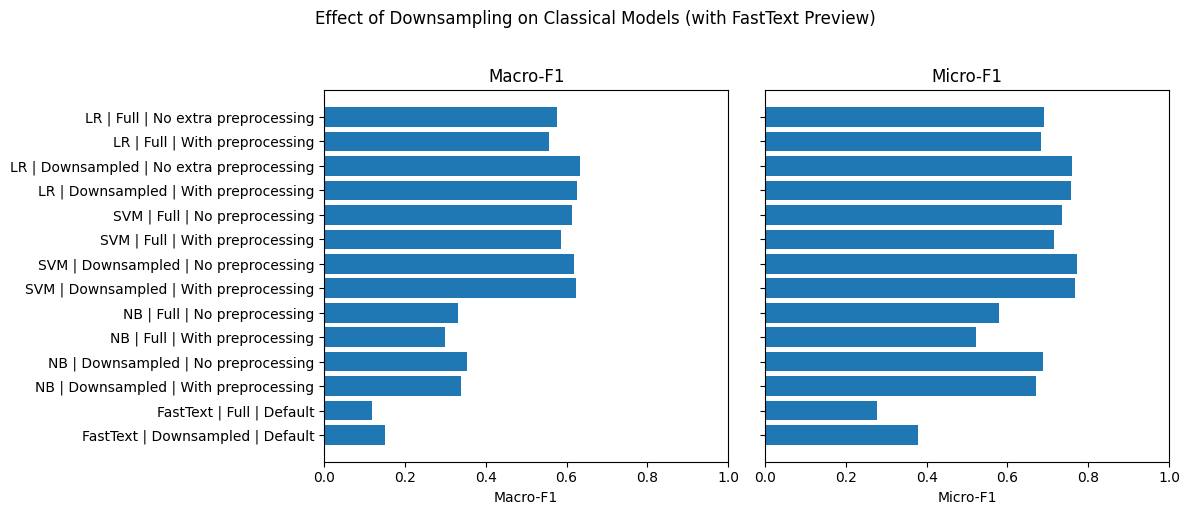

In [64]:
import pandas as pd
import matplotlib.pyplot as plt

# ----------------------------
# 1) Input your results table
# ----------------------------
rows = [
    ("LR",  "FULL",       "No extra preprocessing",   0.882500, 0.575123, 0.691629),
    ("LR",  "FULL",       "With preprocessing",       0.881404, 0.556254, 0.682692),
    ("LR",  "DOWNSAMPLED","No extra preprocessing",   0.653416, 0.633539, 0.759075),
    ("LR",  "DOWNSAMPLED","With preprocessing",       0.655349, 0.624950, 0.757838),

    ("SVM", "FULL",       "No preprocessing",         0.906846, 0.614584, 0.733881),
    ("SVM", "FULL",       "With preprocessing",       0.897321, 0.587391, 0.714786),
    ("SVM", "DOWNSAMPLED","No preprocessing",         0.684886, 0.617554, 0.771553),
    ("SVM", "DOWNSAMPLED","With preprocessing",       0.678675, 0.624416, 0.768179),

    ("NB",  "FULL",       "No preprocessing",         0.911327, 0.330099, 0.578137),
    ("NB",  "FULL",       "With preprocessing",       0.909008, 0.299693, 0.523381),
    ("NB",  "DOWNSAMPLED","No preprocessing",         0.669427, 0.352243, 0.687758),
    ("NB",  "DOWNSAMPLED","With preprocessing",       0.661560, 0.337493, 0.670998),

    # FastText "sneak peek" rows (treated as another model family)
    ("FastText", "FULL",       "Default",             0.9003603321322262, 0.11920246669852845, 0.27737397420867527),
    ("FastText", "DOWNSAMPLED","Default",             0.6150448585231194, 0.1514672849040953,  0.37918970770793364),
]

df = pd.DataFrame(rows, columns=["Model", "Dataset", "Preprocessing", "Accuracy", "MacroF1", "MicroF1"])

# ----------------------------
# 2) Build a clean y-axis label
# ----------------------------
def make_label(r):
    ds = "Full" if r["Dataset"] == "FULL" else "Downsampled"
    return f'{r["Model"]} | {ds} | {r["Preprocessing"]}'

df["Label"] = df.apply(make_label, axis=1)

# Choose an order that reads well: by Model, then Dataset, then Preprocessing
model_order = ["LR", "SVM", "NB", "FastText"]
dataset_order = {"FULL": 0, "DOWNSAMPLED": 1}
prep_order = {"No extra preprocessing": 0, "No preprocessing": 0, "Default": 0, "With preprocessing": 1}

df["ModelSort"] = df["Model"].apply(lambda m: model_order.index(m) if m in model_order else 999)
df["DatasetSort"] = df["Dataset"].map(dataset_order)
df["PrepSort"] = df["Preprocessing"].map(prep_order).fillna(99)

df = df.sort_values(["ModelSort", "DatasetSort", "PrepSort"]).reset_index(drop=True)

# ----------------------------
# 3) Horizontal bar helper
# ----------------------------
fig, axes = plt.subplots(
    nrows=1,
    ncols=2,
    figsize=(12, max(5, 0.35 * len(df))),
    sharey=True
)

# --- Macro-F1 ---
axes[0].barh(df["Label"], df["MacroF1"])
axes[0].set_xlim(0, 1.0)
axes[0].set_title("Macro-F1")
axes[0].set_xlabel("Macro-F1")
axes[0].invert_yaxis()

# --- Micro-F1 ---
axes[1].barh(df["Label"], df["MicroF1"])
axes[1].set_xlim(0, 1.0)
axes[1].set_title("Micro-F1")
axes[1].set_xlabel("Micro-F1")

plt.suptitle("Effect of Downsampling on Classical Models (with FastText Preview)", y=1.02)
plt.tight_layout()
plt.savefig("macro_micro_f1_side_by_side.png", dpi=200, bbox_inches="tight")
plt.show()

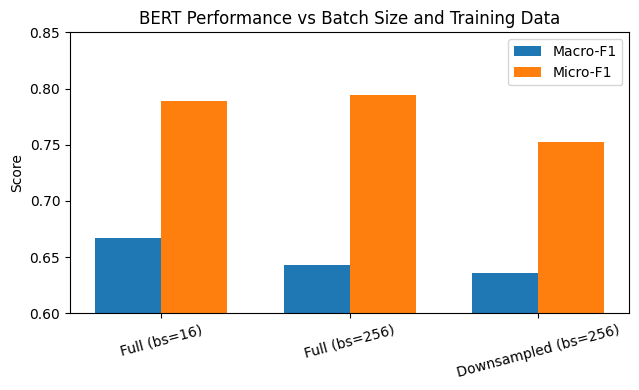

In [65]:
import matplotlib.pyplot as plt
import numpy as np

labels = ["Full (bs=16)", "Full (bs=256)", "Downsampled (bs=256)"]
macro_f1 = [0.6673, 0.6432, 0.6359]
micro_f1 = [0.7887, 0.7939, 0.7522]

x = np.arange(len(labels))
width = 0.35

plt.figure(figsize=(6.5, 4))
plt.bar(x - width/2, macro_f1, width, label="Macro-F1")
plt.bar(x + width/2, micro_f1, width, label="Micro-F1")

plt.xticks(x, labels, rotation=15)
plt.ylim(0.6, 0.85)
plt.ylabel("Score")
plt.title("BERT Performance vs Batch Size and Training Data")
plt.legend()
plt.tight_layout()
plt.savefig("bert_batch_size_comparison.png", dpi=200)
plt.show()
